In [1]:
import cv2 
import numpy as np
import glob
import os
from itertools import combinations 
from itertools import product
import random
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import keras 
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Input, Flatten, Subtract, merge,Conv2D,Lambda,concatenate
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.models import Model,Sequential
#from keras.initializers.h as 

from keras.regularizers import l2 
from pandas import read_excel

#pip install xlrd

Using TensorFlow backend.


In [3]:
path_input_images =  '/tensorflow/IITD_Database/'

In [4]:
data_in_labels_path  = '/tensorflow/accurate_iitd.xlsx'

In [5]:
data = read_excel(data_in_labels_path, sheetname='Sheet1')

/usr/local/lib/python3.5/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [6]:
data.head()

,image_name,R1p,Y1p,X1p,R1s,Y1s,X1s
0,001_01.bmp,45,131,143,98,132,148
1,001_02.bmp,46,147,133,98,147,138
2,001_03.bmp,47,146,133,98,146,137
3,001_04.bmp,47,153,126,98,153,130
4,001_05.bmp,47,150,122,98,149,126


In [7]:
rows = data[data['image_name']=='001_04.bmp']

In [8]:
rows['Y1p'].iloc[0]

153

In [9]:
def read_simaese_parametric_data(path_input_images, folder_name_list_batch,data,batch_size):
    
    train_out1 = np.zeros((40*batch_size,256,512,3),'float')
    train_out2 = np.zeros((40*batch_size,256,512,3),'float')
    out1= np.zeros((40*batch_size,240,320,3),'float')
    out2= np.zeros((40*batch_size,240,320,3),'float')

    pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
    pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

    neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
    #
    count = 0
    y = np.zeros((40*batch_size,13),'float')
    
    for folder_name in folder_name_list_batch:

        for i in range (len(pos_comb1)):
           
        
            ## read the image from folder in postive combination 
            img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
            
            ##get the correspondance segmentation data 
            row1_0 = data[data['image_name']==folder_name + '_'+ str(pos_comb1[i][0]).zfill(2)+'.bmp']
            row1_1 = data[data['image_name']==folder_name + '_'+ str(pos_comb1[i][1]).zfill(2)+'.bmp']
           
            ## save the image data to out and out2         
            out1[count]  = img1_0
            out2[count]  = img1_1
            
            #save the segmentation data to lable 
            y[count,0] = row1_0['Y1s'].iloc[0]
            y[count,1] = row1_0['X1s'].iloc[0]
            y[count,2] = row1_0['R1s'].iloc[0]
            y[count,3] = row1_0['Y1p'].iloc[0]
            y[count,4] = row1_0['X1p'].iloc[0]
            y[count,5] = row1_0['R1p'].iloc[0]
            
            y[count,6] = row1_1['Y1s'].iloc[0]
            y[count,7] = row1_1['X1s'].iloc[0]
            y[count,8] = row1_1['R1s'].iloc[0]
            y[count,9] = row1_1['Y1p'].iloc[0]
            y[count,10] = row1_1['X1p'].iloc[0]
            y[count,11] = row1_1['R1p'].iloc[0]
            
            ## posive combination assigning 0 to last clolumn
            y[count,12] = 0.0
            
            ## increament the count
            count = count+1
            

            img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
            img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
            
            row2_0 = data[data['image_name']==folder_name + '_'+ str(pos_comb2[i][0]).zfill(2)+'.bmp']
            row2_1 = data[data['image_name']==folder_name + '_'+ str(pos_comb2[i][1]).zfill(2)+'.bmp']
            out1[count]  = img2_0
            out2[count]  = img2_1
            
            y[count,0] = row2_0['Y1s'].iloc[0]
            y[count,1] = row2_0['X1s'].iloc[0]
            y[count,2] = row2_0['R1s'].iloc[0]
            y[count,3] = row2_0['Y1p'].iloc[0]
            y[count,4] = row2_0['X1p'].iloc[0]
            y[count,5] = row2_0['R1p'].iloc[0]
            
            y[count,6] = row2_1['Y1s'].iloc[0]
            y[count,7] = row2_1['X1s'].iloc[0]
            y[count,8] = row2_1['R1s'].iloc[0]
            y[count,9] = row2_1['Y1p'].iloc[0]
            y[count,10] = row2_1['X1p'].iloc[0]
            y[count,11] = row2_1['R1p'].iloc[0]
            y[count,12] = 0.0
            count = count+1

            
            ## negative combination left vs right iris for same person 
            folder_name2 = str(int(folder_name) + 1).zfill(3)
            img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
            img3_1 = cv2.imread(path_input_images + folder_name2 + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp')
            
            row3_0 = data[data['image_name']==folder_name + '_'+ str(neg_comb1[i][0]).zfill(2)+'.bmp']
            row3_1 = data[data['image_name']==folder_name2 + '_'+ str(neg_comb1[i][1]).zfill(2)+'.bmp']
            
            out1[count]  = img3_0
            out2[count]  = img3_1

            y[count,0] = row3_0['Y1s'].iloc[0]
            y[count,1] = row3_0['X1s'].iloc[0]
            y[count,2] = row3_0['R1s'].iloc[0]
            y[count,3] = row3_0['Y1p'].iloc[0]
            y[count,4] = row3_0['X1p'].iloc[0]
            y[count,5] = row3_0['R1p'].iloc[0]
            
            y[count,6] = row3_1['Y1s'].iloc[0]
            y[count,7] = row3_1['X1s'].iloc[0]
            y[count,8] = row3_1['R1s'].iloc[0]
            y[count,9] = row3_1['Y1p'].iloc[0]
            y[count,10] = row3_1['X1p'].iloc[0]
            y[count,11] = row3_1['R1p'].iloc[0]
            ## assigning 1 to negative combinations (left vs right image)
            y[count,12] = 1.0
            count = count+1

            
            ## creating the negativ combination from diffrent person 
            folder_name1 = str(int(folder_name) + 3).zfill(3) 
            img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
            
            row4_0 = data[data['image_name']==folder_name + '_'+ str(pos_comb1[i][0]).zfill(2)+'.bmp']
            row4_1 = data[data['image_name']==folder_name1 + '_'+ str(pos_comb1[i][1]).zfill(2)+'.bmp']

            out1[count]  = img4_0
            out2[count]  = img4_1

            y[count,0] = row4_0['Y1s'].iloc[0]
            y[count,1] = row4_0['X1s'].iloc[0]
            y[count,2] = row4_0['R1s'].iloc[0]
            y[count,3] = row4_0['Y1p'].iloc[0]
            y[count,4] = row4_0['X1p'].iloc[0]
            y[count,5] = row4_0['R1p'].iloc[0]
            
            y[count,6] = row4_1['Y1s'].iloc[0]
            y[count,7] = row4_1['X1s'].iloc[0]
            y[count,8] = row4_1['R1s'].iloc[0]
            y[count,9] = row4_1['Y1p'].iloc[0]
            y[count,10] = row4_1['X1p'].iloc[0]
            y[count,11] = row4_1['R1p'].iloc[0]
            y[count,12] = 1.0
            count = count+1
            
    ## this padding the data set for size 256x512 to maintain spect rationa nd segmentation parameters         
    train_out1[:,0:240,0:320,:] = out1
    train_out2[:,0:240,0:320,:] = out2        
    return train_out1,train_out2,y
        #print(count) 

In [10]:
print(np.array(list(product([2,3,4,5], [8,9,10]))))

[[ 2  8]
 [ 2  9]
 [ 2 10]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 5  8]
 [ 5  9]
 [ 5 10]]


In [11]:
#fileList = listOfFiles     
def imageLoader(path_input_images,folder_name_list,batch_size):

    L = len(folder_name_list)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            train_out1,train_out2,y_train = read_simaese_parametric_data(path_input_images,folder_name_list[batch_start:limit],data,batch_size)
            train_out1 = train_out1/255.
            train_out2 = train_out2/255.
            
            ## just for the test 
            #yield ([train_out1,train_out2],y_train[:,0:12])
            
            ## original
            yield ([train_out1,train_out2],y_train) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [12]:
folder_names = np.sort(os.listdir(path_input_images))
folder_name_list = folder_names[0:200] 
folder_name_list_test = folder_names[200:220]
print(len(folder_name_list_test))

20


### Function to check the GT and loader 

In [13]:
def draw_haugh_circle(img_L,img_R, hough_param):        
    
    
    print('pair_classification =', int(hough_param[12]))
    cimg = img_L.copy()
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),int(hough_param[2]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),int(hough_param[5]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),2,(0,0,255),3)
    plt.title('left_image')
    plt.imshow(cimg)
    plt.show()
    
    
    cimg = img_R.copy()
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),int(hough_param[8]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),int(hough_param[11]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),2,(0,0,255),3)
    plt.title('right_image')
    plt.imshow(cimg)
    plt.show()

In [14]:
Out = next((imageLoader(path_input_images,folder_name_list,1)))



In [15]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]
y = Out[1]


In [16]:
y[:,12]

array([0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pair_classification = 0


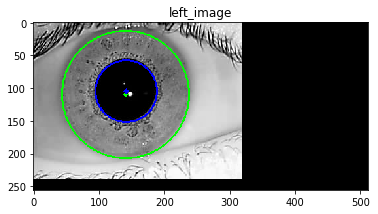

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


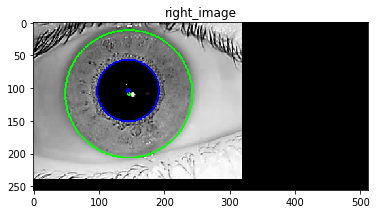

In [17]:
num = 9
draw_haugh_circle(image_L[num],image_R[num],y[num])

In [18]:
print(y.shape)

(40, 13)


In [19]:
#pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
#pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

#neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
#print(neg_comb1)

In [20]:
folder_names = np.sort(os.listdir(path_input_images))

print(folder_names[0:20])

['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020']


In [21]:
initialize_weights = 'he_normal'
initialize_bias = 'he_normal'

In [22]:
def Siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    n_filters = 16
    dropout=.1
    
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(1*n_filters, (3,3), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2)))           # (h/2,w/2,16)
    model.add(Dropout(dropout))
    
   
    model.add(Conv2D(2*n_filters, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2)))           # (h/4,w/4,32)
    model.add(Dropout(dropout)) 
    
   
    model.add(Conv2D(4*n_filters, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2)))           # (h/8,w/8,64)
    model.add(Dropout(dropout)) 
    
  
    model.add(Conv2D(8*n_filters, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2)))           # (h/16,w/16,128)
    model.add(Dropout(dropout))
    
    model.add(Conv2D(16*n_filters, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    
    model.add(MaxPooling2D((2,2)))           # (h/32,w/32,256)
    model.add(Dropout(dropout))
    
    model.add(Conv2D(32*n_filters, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
#     model.add(Dense(128, activation='sigmoid',
#                    kernel_regularizer=l2(1e-3),
#                    kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l_flatten = model(left_input)
    encoded_r_flatten = model(right_input)
    
    encoded_l = Dense(128, activation ='sigmoid')(encoded_l_flatten)
    encoded_r = Dense(128, activation ='sigmoid')(encoded_r_flatten)
    
    
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
        # Add a dense layer with a sigmoid unit to generate the similarity score
    class_label = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    
    encoded_l_outputs = Dense(6, activation ='linear')(encoded_l_flatten)
    encoded_r_outputs = Dense(6, activation ='linear')(encoded_r_flatten)

    
    ## only for testing removing class label
    #prediction = concatenate([encoded_l_outputs, encoded_r_outputs])
    
    prediction = concatenate([encoded_l_outputs, encoded_r_outputs, class_label])
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction,name='Siamese_model')
    
    # return the model
    return siamese_net

In [23]:
siamese_model = Siamese_model((256,512,3))

In [24]:
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 24576)        1572768     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          3145856     sequential_1[1][0]               
__________

In [25]:
def custom_loss(y_true, y_pred):
 
    # calculating mean square error between target and predicted values 
    #mean_loss = K.mean(K.square(y_pred[:,0:12] - y_true[:,0:12]), axis=-1)   ## batchsize ,13
    #mnea_loss  = 
    mean_loss = tf.keras.losses.mean_squared_error(y_true[:,0:12], y_pred[:,0:12])
    
    ## calculate cross entrophy error 
    cross_entropy_loss = K.binary_crossentropy(y_true[:,12], y_pred[:,12], from_logits=False)
    
    ## only training for parametric loss  
   
    
    loss  = concatenate([mean_loss,cross_entropy_loss])
    # multiplying the values with weights along batch dimension
    #loss = loss * [0.3, 0.7]          # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    
    loss = K.sum(loss)        # (batch_size,)
    print('mean_square_loss  =', mean_loss)
    print('cross_entropy_loss  =', cross_entropy_loss)
    return loss

In [26]:
#optimizer = keras.optimizers.Adam(lr = 0.00006)

#siamese_model.compile(loss='mean_squared_error', optimizer='Adam', metrics = ['mae', 'acc'])
siamese_model.compile(loss=custom_loss, optimizer='Adam', metrics = ['mae', 'acc'])
#siamese_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ["accuracy"])

mean_square_loss  = Tensor("loss/concatenate_1_loss/Mean:0", shape=(?,), dtype=float32)
cross_entropy_loss  = Tensor("loss/concatenate_1_loss/logistic_loss:0", shape=(?,), dtype=float32)


In [27]:
#steps_per_epoch = train_length // batch_size
batch_size = 1
steps_per_epoch = len(folder_name_list) // batch_size
validation_steps = len(folder_name_list_test) // batch_size

In [28]:
#siamese_model.fit([out1,out2],  y,epochs=100, batch_size = 4)
history = siamese_model.fit_generator(imageLoader(path_input_images,folder_name_list,batch_size),steps_per_epoch,
                    validation_data = imageLoader(path_input_images,folder_name_list_test,batch_size), 
                    validation_steps=validation_steps, epochs=50)

Epoch 1/50
200/200 [==============================] - 105s 525ms/step - loss: 44267.8573 - mean_absolute_error: 22.4032 - acc: 0.2690 - val_loss: 134748.0570 - val_mean_absolute_error: 48.8902 - val_acc: 0.3287
Epoch 2/50
200/200 [==============================] - 102s 512ms/step - loss: 18325.0320 - mean_absolute_error: 14.2105 - acc: 0.3782 - val_loss: 67230.5176 - val_mean_absolute_error: 33.7646 - val_acc: 0.4950
Epoch 3/50
200/200 [==============================] - 102s 508ms/step - loss: 10220.4635 - mean_absolute_error: 9.8387 - acc: 0.4051 - val_loss: 29617.7893 - val_mean_absolute_error: 21.1061 - val_acc: 0.5575
Epoch 4/50
200/200 [==============================] - 100s 502ms/step - loss: 7635.1953 - mean_absolute_error: 7.9765 - acc: 0.4340 - val_loss: 16526.6995 - val_mean_absolute_error: 15.3387 - val_acc: 0.4838
Epoch 5/50
200/200 [==============================] - 101s 503ms/step - loss: 6497.3438 - mean_absolute_error: 7.0078 - acc: 0.4360 - val_loss: 10697.4400 - val_m

200/200 [==============================] - 100s 500ms/step - loss: 1594.4821 - mean_absolute_error: 3.5708 - acc: 0.5961 - val_loss: 723.8538 - val_mean_absolute_error: 2.8045 - val_acc: 0.7275
Epoch 41/50
200/200 [==============================] - 100s 499ms/step - loss: 958.7668 - mean_absolute_error: 3.0873 - acc: 0.6612 - val_loss: 922.4733 - val_mean_absolute_error: 3.2813 - val_acc: 0.7600
Epoch 42/50
200/200 [==============================] - 100s 499ms/step - loss: 1107.4736 - mean_absolute_error: 3.1047 - acc: 0.6371 - val_loss: 1004.5368 - val_mean_absolute_error: 3.4287 - val_acc: 0.7625
Epoch 43/50
200/200 [==============================] - 100s 499ms/step - loss: 1519.8161 - mean_absolute_error: 3.4793 - acc: 0.6071 - val_loss: 683.3157 - val_mean_absolute_error: 2.6603 - val_acc: 0.6963
Epoch 44/50
200/200 [==============================] - 100s 500ms/step - loss: 1369.7914 - mean_absolute_error: 3.5373 - acc: 0.6199 - val_loss: 821.8160 - val_mean_absolute_error: 3.0574 

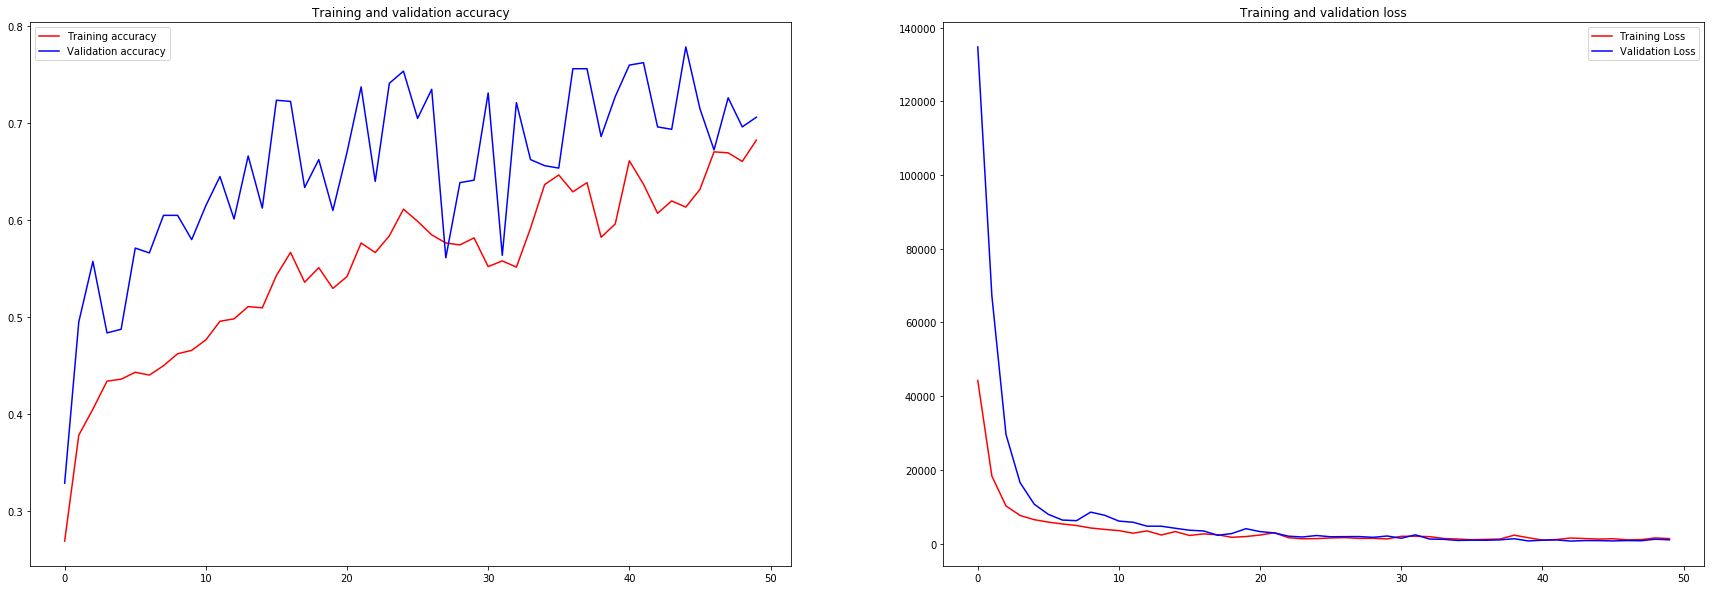

In [29]:
import matplotlib.pyplot as plt
# Let's take a look at how we did during training.
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accuracy
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

# Loss
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [30]:
model_save_path = '/tensorflow/samese_model/unet_saimese_parametric_50epoch.h5'

siamese_model.save(model_save_path)